In [ ]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, lower, trim
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("JobSkillsWordCloud") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

jobs_df = spark.read.csv("/scratch/stp8232/Big Data/linkedin_job_postings.csv", header=True, inferSchema=True)
skills_df = spark.read.csv("/scratch/stp8232/Big Data/job_skills.csv", header=True, inferSchema=True)

# Filter out null job_skills and split/explode the skills
df_skills = skills_df.filter(col("job_skills").isNotNull()) \
    .withColumn("skill", explode(split(col("job_skills"), ", "))) \
    .withColumn("skill", trim(lower(col("skill"))))  # Convert to lowercase and trim whitespace

# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(["and", "for", "the", "in", "of"])  # Add custom stopwords

# Filter out stopwords
df_skills_filtered = df_skills.filter(~col("skill").isin(list(stopwords)))

# Aggregate to get the top 20 skills (based on frequency)
top_skills = df_skills_filtered.groupBy("skill") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(30)

top_skills_list = top_skills.collect()
print("Top 30 Job Skills (with frequencies):")
for row in top_skills_list:
    print(f"{row['skill']}: {row['count']}")

# Stop Spark session
spark.stop()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 18:08:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Top 30 Job Skills (with frequencies):
communication: 370052
customer service: 278033
teamwork: 227548
communication skills: 195837
leadership: 185138
problem solving: 148992
time management: 142873
attention to detail: 133929
problemsolving: 129299
project management: 121525
interpersonal skills: 100223
patient care: 99912
sales: 92983
nursing: 87949
collaboration: 87086
training: 83639
data analysis: 81949
microsoft office suite: 75508
organizational skills: 75257
inventory management: 71902
high school diploma: 67244
scheduling: 64452
bachelor's degree: 63451
multitasking: 62025
analytical skills: 60742
microsoft office: 60587
adaptability: 59101
flexibility: 56870
critical thinking: 53073
documentation: 51866


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, collect_list, size, array_distinct

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("SkillCooccurrenceAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load datasets
skills_df = spark.read.csv("/scratch/stp8232/Big Data/job_skills.csv", header=True, inferSchema=True)

# Filter and explode skills
df_skills = skills_df.filter(col("job_skills").isNotNull()) \
    .withColumn("skill", explode(split(col("job_skills"), ", ")))

# Group by job_link to get all skills per posting
skill_groups = df_skills.groupBy("job_link") \
    .agg(collect_list("skill").alias("skills")) \
    .withColumn("skills", array_distinct(col("skills")))

# Generate skill pairs
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def get_pairs(skills):
    pairs = []
    for i in range(len(skills)):
        for j in range(i + 1, len(skills)):
            pairs.append((skills[i], skills[j]))
    return pairs

pair_udf = udf(get_pairs, ArrayType(ArrayType(StringType())))
skill_pairs = skill_groups.withColumn("skill_pairs", explode(pair_udf(col("skills"))))

# Aggregate co-occurrence counts
cooccurrence_df = skill_pairs.groupBy("skill_pairs") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)  # Top 10 pairs

# Collect data for visualization
cooccurrence_data = cooccurrence_df.collect()
pairs = [(row["skill_pairs"][0], row["skill_pairs"][1]) for row in cooccurrence_data]
counts = [row["count"] for row in cooccurrence_data]

# Stop Spark session
spark.stop()

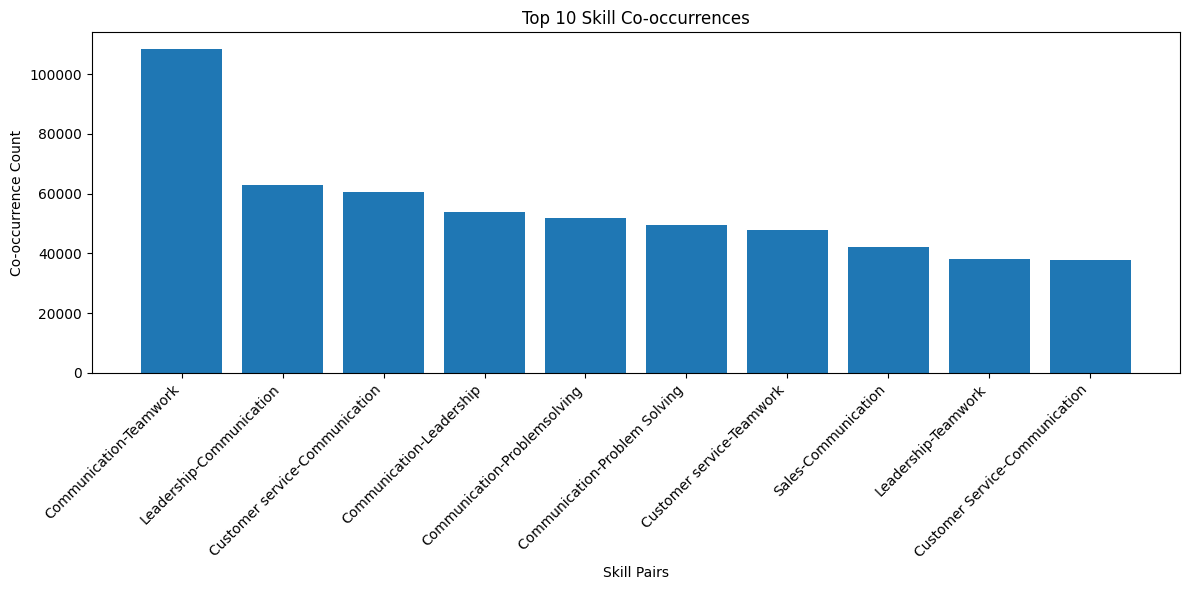

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(len(pairs)), counts, tick_label=[f"{p[0]}-{p[1]}" for p in pairs])
plt.xlabel("Skill Pairs")
plt.ylabel("Co-occurrence Count")
plt.title("Top 10 Skill Co-occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("skill_cooccurrence.png")
plt.show()

In [ ]:
# Fixed Enhanced LinkedIn Job Market Analysis
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer, StopWordsRemover, NGram
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Enhanced LinkedIn Job Market Analysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Define file paths
linkedin_data_path = "/scratch/stp8232/Big Data/linkedin_job_postings.csv"
job_summary_path = "/scratch/stp8232/Big Data/job_summary.csv"

# Create output directory for visualizations
output_dir = "job_market_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Load data
print("Loading datasets...")
linkedin_df = spark.read.csv(linkedin_data_path, header=True, inferSchema=True)
job_summary_df = spark.read.csv(job_summary_path, header=True, inferSchema=True)

# Print dataset info
print(f"LinkedIn dataset: {linkedin_df.count()} rows")
print(f"Job Summary dataset: {job_summary_df.count()} rows")

# Basic data cleaning
def clean_dataframes():
    global linkedin_df, job_summary_df

    print("Cleaning LinkedIn dataset...")

    # Handle null values in LinkedIn dataset
    for column_name in linkedin_df.columns:
        null_count = linkedin_df.filter(F.col(column_name).isNull()).count()
        print(f"Column {column_name} has {null_count} null values")

    # Convert date columns
    if "first_seen" in linkedin_df.columns:
        linkedin_df = linkedin_df.withColumn("first_seen_date",
                                           F.to_date(F.col("first_seen")))

    # Fix malformed data: Ensure job_level and job_type values are consistent
    # Create mapping dictionaries for standardization
    job_level_map = {
        "Associate": "Entry Level",
        "Mid senior": "Mid-Senior Level"
    }

    job_type_map = {
        "Onsite": "On-site",
        "Remote": "Remote",
        "Hybrid": "Hybrid"
    }

    # Standardize job level values
    for old_value, new_value in job_level_map.items():
        linkedin_df = linkedin_df.withColumn(
            "job_level_std",
            F.when(F.col("job_level") == old_value, new_value)
            .otherwise(F.col("job_level"))
        )

    # Standardize job type values
    for old_value, new_value in job_type_map.items():
        linkedin_df = linkedin_df.withColumn(
            "job_type_std",
            F.when(F.col("job_type") == old_value, new_value)
            .otherwise(F.col("job_type"))
        )

    # Clean job summary dataset
    print("Cleaning Job Summary dataset...")

    # Group by job_link and concatenate summaries
    job_summary_df = job_summary_df.groupBy("job_link").agg(
        F.concat_ws(" ", F.collect_list("job_summary")).alias("job_summary")
    )

    # Clean text in job summaries - if time permits
    try:
        job_summary_df = job_summary_df.withColumn(
            "job_summary_clean",
            F.regexp_replace(F.col("job_summary"), "[^a-zA-Z0-9\\s]", " ")
        )

        # Convert to lowercase
        job_summary_df = job_summary_df.withColumn(
            "job_summary_clean",
            F.lower(F.col("job_summary_clean"))
        )

        # Remove extra whitespace
        job_summary_df = job_summary_df.withColumn(
            "job_summary_clean",
            F.regexp_replace(F.col("job_summary_clean"), "\\s+", " ")
        )
    except Exception as e:
        print(f"Warning: Could not create clean job summary column: {str(e)}")
        print("Continuing without clean job summary column")

    print("Data cleaning completed")
    return linkedin_df, job_summary_df

# Join LinkedIn data with job summaries
def merge_dataframes(linkedin_df, job_summary_df):
    print("Merging LinkedIn data with job summaries...")

    # Join on job_link
    merged_df = linkedin_df.join(
        job_summary_df,
        on="job_link",
        how="left"
    )

    print(f"Merged dataframe has {merged_df.count()} rows")
    matched_count = merged_df.filter(F.col("job_summary").isNotNull()).count()
    print(f"Jobs with summaries: {matched_count} ({matched_count/merged_df.count()*100:.2f}%)")

    return merged_df

# -------------------------------------------------------------------------------
# Enhanced Analysis Functions
# -------------------------------------------------------------------------------

# Analyze top locations - THIS WAS MISSING
def analyze_top_locations(df):
    print("Analyzing job locations...")

    if "job_location" not in df.columns:
        print("No job_location column available.")
        return None

    # Extract state from location (assuming format like "City, State")
    df = df.withColumn(
        "state",
        F.when(F.col("job_location").contains(", "),
              F.split(F.col("job_location"), ", ").getItem(1))
        .otherwise("Unknown")
    )

    # Top locations (cities)
    location_counts = df.groupBy("job_location").count().orderBy(F.desc("count"))
    print("Top job locations:")
    location_counts.show(10, truncate=False)

    # Top states
    state_counts = df.groupBy("state").count().orderBy(F.desc("count"))
    print("Top states for jobs:")
    state_counts.show(10, truncate=False)

    return {
        "location_counts": location_counts,
        "state_counts": state_counts
    }

# Industry Analysis based on job titles and descriptions
def analyze_industries(df):
    print("Analyzing industries based on job titles and descriptions...")

    # Define industry keywords
    industry_keywords = {
        "Healthcare": ["health", "medical", "nurse", "doctor", "patient", "hospital", "clinical", "healthcare"],
        "Technology": ["software", "developer", "engineer", "tech", "IT", "programming", "data", "analytics"],
        "Finance": ["finance", "accounting", "banker", "investment", "financial", "analyst", "bank"],
        "Retail": ["retail", "sales", "customer", "store", "manager", "associate", "merchandising"],
        "Education": ["education", "teacher", "professor", "tutor", "school", "academic", "teaching"],
        "Manufacturing": ["manufacturing", "production", "assembly", "quality", "maintenance", "operator"],
        "Hospitality": ["hospitality", "restaurant", "hotel", "food", "service", "chef", "catering"]
    }

    # Count jobs matching industry keywords in title or description
    industry_counts = []

    for industry, keywords in industry_keywords.items():
        # Create keyword conditions
        title_conditions = [F.lower(F.col("job_title")).contains(keyword.lower()) for keyword in keywords]

        # Combine conditions with OR
        title_condition = title_conditions[0]
        for condition in title_conditions[1:]:
            title_condition = title_condition | condition

        # Count matching jobs
        if "job_summary" in df.columns:
            summary_conditions = [F.lower(F.col("job_summary")).contains(keyword.lower()) for keyword in keywords]
            summary_condition = summary_conditions[0]
            for condition in summary_conditions[1:]:
                summary_condition = summary_condition | condition

            # Jobs that match in either title or summary
            count = df.filter(title_condition | summary_condition).count()
        else:
            # If no summary, just use title
            count = df.filter(title_condition).count()

        industry_counts.append((industry, count))

    # Create a DataFrame from the counts
    industry_df = spark.createDataFrame(industry_counts, ["Industry", "Count"])
    industry_df = industry_df.orderBy(F.desc("Count"))

    print("Job counts by industry:")
    industry_df.show()

    return industry_df

# Skill Gap Analysis
def perform_skill_gap_analysis(df, vocabulary):
    print("Performing skill gap analysis...")

    if vocabulary is None:
        print("No vocabulary available for skill gap analysis.")
        return None, None

    # Define skill categories
    skill_categories = {
        "Technical": ["python", "java", "sql", "aws", "cloud", "api", "data", "analytics",
                     "machine", "learning", "ai", "algorithm", "programming", "software",
                     "excel", "tableau", "powerbi", "css", "html", "javascript"],
        "Soft": ["communication", "teamwork", "leadership", "problem", "solving", "critical",
                "thinking", "collaboration", "interpersonal", "creativity", "adaptability"],
        "Business": ["management", "strategy", "marketing", "sales", "finance", "accounting",
                    "operations", "project", "business", "development", "customer"]
    }

    # Categorize skills from vocabulary
    categorized_skills = {}
    for category, keywords in skill_categories.items():
        category_skills = []
        for term in vocabulary:
            if any(keyword in term.lower() for keyword in keywords):
                category_skills.append(term)
        categorized_skills[category] = category_skills

    # Print categorization results
    print("\nSkill categorization:")
    for category, skills in categorized_skills.items():
        print(f"{category} skills ({len(skills)}):")
        print(", ".join(skills[:10]) + ("..." if len(skills) > 10 else ""))

    # Simplified skill gap analysis
    skill_mentions = {}
    job_type_col = "job_type_std" if "job_type_std" in df.columns else "job_type"

    if job_type_col in df.columns and df.count() > 0:
        # Get distinct job types
        job_types = [r[0] for r in df.select(job_type_col).distinct().collect() if r[0] is not None]

        for job_type in job_types[:3]:  # Limit to top 3 job types for performance
            # Sample jobs of this type
            sample_df = df.filter(F.col(job_type_col) == job_type).limit(1000)

            # Collect sample summaries
            if "job_summary" in df.columns:
                summaries = [r[0] for r in sample_df.select("job_summary").collect() if r[0] is not None]
                all_text = " ".join(summaries).lower()

                # Count skill category mentions
                skill_mentions[job_type] = {}
                for category, skills in categorized_skills.items():
                    mention_count = sum(1 for skill in skills if skill.lower() in all_text)
                    skill_mentions[job_type][category] = {
                        "count": mention_count,
                        "percentage": (mention_count / len(skills)) * 100 if len(skills) > 0 else 0
                    }

    # Print skill gap analysis results
    if skill_mentions:
        print("\nSkill category mentions by job type (sample):")
        for job_type, categories in skill_mentions.items():
            print(f"\n{job_type} jobs:")
            for category, stats in categories.items():
                print(f"  {category} skills: {stats['count']} mentions ({stats['percentage']:.2f}%)")

    return categorized_skills, skill_mentions

# Analyze top job titles
def analyze_job_titles(df):
    print("Analyzing job titles...")

    if "job_title" not in df.columns:
        print("No job_title column available.")
        return None

    # Most common job titles
    title_counts = df.groupBy("job_title").count().orderBy(F.desc("count"))
    print("Top job titles:")
    title_counts.show(20, truncate=False)

    # Extract key roles from titles
    common_roles = ["manager", "engineer", "developer", "analyst", "assistant",
                   "representative", "specialist", "director", "consultant", "coordinator"]

    role_counts = []
    for role in common_roles:
        count = df.filter(F.lower(F.col("job_title")).contains(role)).count()
        role_counts.append((role.capitalize(), count))

    role_df = spark.createDataFrame(role_counts, ["Role", "Count"])
    role_df = role_df.orderBy(F.desc("Count"))

    print("Key roles in job titles:")
    role_df.show()

    return {
        "title_counts": title_counts,
        "role_counts": role_df
    }

# Extract skills from job descriptions
def extract_skills(df):
    print("Extracting skills from job descriptions...")

    if "job_summary" not in df.columns:
        print("No job_summary column available.")
        return None, None

    # Filter out null summaries and ensure they're long enough to analyze
    df_with_summaries = df.filter(
        F.col("job_summary").isNotNull() &
        (F.length("job_summary") > 20)
    )

    sample_count = min(df_with_summaries.count(), 100000)
    print(f"Processing {sample_count} job summaries")

    # Sample for faster processing
    sample_df = df_with_summaries.limit(sample_count)

    try:
        # Tokenize job summaries
        tokenizer = Tokenizer(inputCol="job_summary", outputCol="words")
        tokenized = tokenizer.transform(sample_df)

        # Remove stop words
        remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
        filtered = remover.transform(tokenized)

        # Use CountVectorizer for term frequency analysis
        cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features",
                            minDF=10.0, vocabSize=5000)
        cv_model = cv.fit(filtered)
        vocabulary = cv_model.vocabulary
        print(f"Extracted {len(vocabulary)} terms from job descriptions")

        # Print top terms
        print("Top 20 terms:")
        for i, term in enumerate(vocabulary[:20], 1):
            print(f"{i}. {term}")

        return vocabulary, filtered
    except Exception as e:
        print(f"Error during skill extraction: {str(e)}")
        return None, None


# Generate summary report
def generate_report(results):
    try:
        summary = ["# LinkedIn Job Market Analysis Summary\n"]

        if "job_count" in results:
            summary.append(f"## Overview\nAnalyzed {results['job_count']} job postings\n")

        if "job_types" is not None and "job_types" in results:
            summary.append("## Job Types")
            for row in results["job_types"].head(10):
                job_type = row["job_type_std"] if "job_type_std" in row else row["job_type"]
                if job_type is not None:
                    summary.append(f"- {job_type}: {row['count']} jobs")
            summary.append("")

        if "job_levels" is not None and "job_levels" in results:
            summary.append("## Job Levels")
            for row in results["job_levels"].head(10):
                job_level = row["job_level_std"] if "job_level_std" in row else row["job_level"]
                if job_level is not None:
                    summary.append(f"- {job_level}: {row['count']} jobs")
            summary.append("")

        if "top_companies" is not None and "top_companies" in results:
            summary.append("## Top 10 Hiring Companies")
            for i, row in enumerate(results["top_companies"].head(10)):
                summary.append(f"- {row['company']}: {row['count']} jobs")
            summary.append("")

        if "top_skills" is not None and "top_skills" in results:
            summary.append("## Top 20 Skills In Demand")
            for i, skill in enumerate(results["top_skills"][:20], 1):
                summary.append(f"{i}. {skill}")
            summary.append("")

        # Add industry analysis if available
        if "industries" is not None and "industries" in results:
            summary.append("## Industry Analysis")
            for row in results["industries"].head(7):
                summary.append(f"- {row['Industry']}: {row['Count']} jobs")
            summary.append("")

        report = "\n".join(summary)
        print("\n" + report)

        with open(f"{output_dir}/job_market_analysis_report.md", "w") as f:
            f.write(report)

        return report
    except Exception as e:
        print(f"Error generating report: {str(e)}")
        return "Error generating report"

# Main execution flow
def main():
    print("Starting Enhanced LinkedIn Job Market Analysis...")

    # Clean the data
    linkedin_df, job_summary_df = clean_dataframes()

    # Merge the dataframes
    merged_df = merge_dataframes(linkedin_df, job_summary_df)

    # Basic analyses
    job_levels = merged_df.groupBy("job_level_std" if "job_level_std" in merged_df.columns else "job_level").count().orderBy(F.desc("count"))
    job_types = merged_df.groupBy("job_type_std" if "job_type_std" in merged_df.columns else "job_type").count().orderBy(F.desc("count"))
    location_results = analyze_top_locations(merged_df)
    company_counts = merged_df.groupBy("company").count().orderBy(F.desc("count"))
    title_results = analyze_job_titles(merged_df)

    # Analyze trends over time
    #time_trends = analyze_time_trends(merged_df)

    # Extract skills from job descriptions
    vocabulary, filtered_df = extract_skills(merged_df)

    # Industry analysis
    industry_df = analyze_industries(merged_df)

    # Skill gap analysis
    if vocabulary is not None:
        categorized_skills, skill_mentions = perform_skill_gap_analysis(merged_df, vocabulary)
    else:
        categorized_skills, skill_mentions = None, None

    # Generate summary report
    results = {
        "job_count": merged_df.count(),
        "job_types": job_types.toPandas() if job_types is not None else None,
        "job_levels": job_levels.toPandas() if job_levels is not None else None,
        "top_companies": company_counts.toPandas() if company_counts is not None else None,
        "top_locations": location_results["state_counts"].toPandas() if location_results else None,
        "top_skills": vocabulary,
        "industries": industry_df.toPandas() if industry_df is not None else None,
    }

    report = generate_report(results)

    print("Enhanced analysis complete! Results saved to:", output_dir)

    # Stop Spark session
    spark.stop()

if __name__ == "__main__":
    main()

<>:379: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:387: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:395: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:401: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:408: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:379: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:387: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:395: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:401: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:408: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Loading datasets...


LinkedIn dataset: 1348488 rows


/tmp/ipykernel_6688/2351142495.py:379: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "job_types" is not None and "job_types" in results:
/tmp/ipykernel_6688/2351142495.py:387: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "job_levels" is not None and "job_levels" in results:
/tmp/ipykernel_6688/2351142495.py:395: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "top_companies" is not None and "top_companies" in results:
/tmp/ipykernel_6688/2351142495.py:401: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "top_skills" is not None and "top_skills" in results:
/tmp/ipykernel_6688/2351142495.py:408: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "industries" is not None and "industries" in results:


Job Summary dataset: 48219735 rows
Starting Enhanced LinkedIn Job Market Analysis...
Cleaning LinkedIn dataset...
Column job_link has 0 null values
Column last_processed_time has 0 null values
Column got_summary has 0 null values
Column got_ner has 0 null values
Column is_being_worked has 0 null values
Column job_title has 0 null values
Column company has 45 null values
Column job_location has 53 null values
Column first_seen has 34 null values
Column search_city has 68 null values
Column search_country has 68 null values
Column search_position has 68 null values
Column job_level has 68 null values
Column job_type has 69 null values
Cleaning Job Summary dataset...
Data cleaning completed
Merging LinkedIn data with job summaries...
Merged dataframe has 1348488 rows


Jobs with summaries: 1297332 (96.21%)
Analyzing job locations...
Top job locations:


+-------------------------------+-----+
|job_location                   |count|
+-------------------------------+-----+
|New York, NY                   |13435|
|London, England, United Kingdom|11756|
|Houston, TX                    |10999|
|Chicago, IL                    |10790|
|Los Angeles, CA                |10262|
|Atlanta, GA                    |9208 |
|Boston, MA                     |8403 |
|Dallas, TX                     |8005 |
|Austin, TX                     |7678 |
|Washington, DC                 |7322 |
+-------------------------------+-----+
only showing top 10 rows

Top states for jobs:
+-------+------+
|state  |count |
+-------+------+
|CA     |117203|
|England|100176|
|TX     |81914 |
|FL     |69616 |
|NY     |57504 |
|PA     |47042 |
|OH     |45251 |
|IL     |42841 |
|VA     |38098 |
|MA     |36883 |
+-------+------+
only showing top 10 rows

Analyzing job titles...
Top job titles:
+---------------------------------------------------+-----+
|job_title                   

Processing 100000 job summaries


Extracted 5000 terms from job descriptions
Top 20 terms:
1. care
2. health
3. -
4. job
5. team
6. work
7. join
8. nursing
9. patient
10. nurse
11. looking
12. experience
13. seeking
14. general
15. healthcare
16. medical
17. position
18. support
19. new
20. travel
Analyzing industries based on job titles and descriptions...


Job counts by industry:
+-------------+------+
|     Industry| Count|
+-------------+------+
|   Technology|770142|
|       Retail|437482|
|   Healthcare|322895|
|  Hospitality|208472|
|Manufacturing|106791|
|      Finance| 81302|
|    Education| 74949|
+-------------+------+

Performing skill gap analysis...

Skill categorization:
Technical skills (119):
training, data, excellent, maintain, available, paid, aids,, daily, maintenance, software...
Soft skills (28):
leadership, critical, communication, collaboration, leadership,, problems, problem, thinking, interpersonal, icu/critical...
Business skills (39):
management, business, customer, development, sales, project, customers, operations, projects, management,...



Skill category mentions by job type (sample):

Remote jobs:
  Technical skills: 57 mentions (47.90%)
  Soft skills: 16 mentions (57.14%)
  Business skills: 28 mentions (71.79%)

Onsite jobs:
  Technical skills: 91 mentions (76.47%)
  Soft skills: 20 mentions (71.43%)
  Business skills: 31 mentions (79.49%)

Hybrid jobs:
  Technical skills: 61 mentions (51.26%)
  Soft skills: 18 mentions (64.29%)
  Business skills: 33 mentions (84.62%)
Error generating report: string indices must be integers
Enhanced analysis complete! Results saved to: job_market_analysis_results


In [ ]:
# LinkedIn Job Market Analysis with Visualizations
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("LinkedIn Job Market Analysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Define file paths
linkedin_data_path = "/scratch/stp8232/Big Data/linkedin_job_postings.csv"
job_summary_path = "/scratch/stp8232/Big Data/job_summary.csv"

# Create output directory for visualizations
output_dir = "job_market_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load and clean data functions
def load_and_clean_data():
    print("Loading datasets...")
    linkedin_df = spark.read.csv(linkedin_data_path, header=True, inferSchema=True)
    job_summary_df = spark.read.csv(job_summary_path, header=True, inferSchema=True)

    print(f"LinkedIn dataset: {linkedin_df.count()} rows")
    print(f"Job Summary dataset: {job_summary_df.count()} rows")

    # Clean LinkedIn dataset
    print("Cleaning LinkedIn dataset...")
    for column_name in linkedin_df.columns:
        null_count = linkedin_df.filter(F.col(column_name).isNull()).count()
        print(f"Column {column_name} has {null_count} null values")

    # Convert date columns
    if "first_seen" in linkedin_df.columns:
        linkedin_df = linkedin_df.withColumn("first_seen_date",
                                           F.to_date(F.col("first_seen")))

    # Clean job summary dataset
    print("Cleaning Job Summary dataset...")
    job_summary_df = job_summary_df.groupBy("job_link").agg(
        F.concat_ws(" ", F.collect_list("job_summary")).alias("job_summary")
    )

    # Merge the dataframes
    print("Merging LinkedIn data with job summaries...")
    merged_df = linkedin_df.join(job_summary_df, on="job_link", how="left")

    print(f"Merged dataframe has {merged_df.count()} rows")
    matched_count = merged_df.filter(F.col("job_summary").isNotNull()).count()
    print(f"Jobs with summaries: {matched_count} ({matched_count/merged_df.count()*100:.2f}%)")

    return merged_df

# Extract skills from job descriptions
def extract_skills(df, sample_size=100000):
    print("Extracting skills from job descriptions...")

    # Filter out null summaries
    df_with_summaries = df.filter(F.col("job_summary").isNotNull())

    # Take sample for performance
    sample_count = min(df_with_summaries.count(), sample_size)
    print(f"Processing {sample_count} job summaries")
    sample_df = df_with_summaries.limit(sample_count)

    # Process text
    tokenizer = Tokenizer(inputCol="job_summary", outputCol="words")
    tokenized = tokenizer.transform(sample_df)

    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    filtered = remover.transform(tokenized)

    # Extract terms
    cv = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=10.0, vocabSize=5000)
    cv_model = cv.fit(filtered)
    vocabulary = cv_model.vocabulary

    print(f"Extracted {len(vocabulary)} terms from job descriptions")
    print("Top 20 terms:")
    for i, term in enumerate(vocabulary[:20], 1):
        print(f"{i}. {term}")

    return vocabulary


def plot_top_locations(df):
    """Plot top job locations"""
    print("Plotting top job locations...")

    if "job_location" not in df.columns:
        print("No job_location column available.")
        return

    # Extract state from location
    df = df.withColumn(
        "state",
        F.when(F.col("job_location").contains(", "),
              F.split(F.col("job_location"), ", ").getItem(1))
        .otherwise("Unknown")
    )

    # Get top states
    state_counts = df.groupBy("state").count().orderBy(F.desc("count")).toPandas()
    top_states = state_counts.head(10)

    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(y='state', x='count', data=top_states)
    plt.title('Top 10 States/Regions for Job Postings', fontsize=16)
    plt.xlabel('Number of Job Postings')
    plt.ylabel('State/Region')

    # Add count labels to bars
    for i, v in enumerate(top_states['count']):
        ax.text(v + 0.1, i, f"{v:,}", va='center')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_states.png", dpi=300)
    plt.close()

    # Get top cities
    city_counts = df.groupBy("job_location").count().orderBy(F.desc("count")).toPandas()
    top_cities = city_counts.head(10)

    # Create horizontal bar chart for cities
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(y='job_location', x='count', data=top_cities)
    plt.title('Top 10 Cities for Job Postings', fontsize=16)
    plt.xlabel('Number of Job Postings')
    plt.ylabel('City')

    # Add count labels to bars
    for i, v in enumerate(top_cities['count']):
        ax.text(v + 0.1, i, f"{v:,}", va='center')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_cities.png", dpi=300)
    plt.close()

    print(f"Location visualizations saved to {output_dir}")

def plot_top_companies(df):
    """Plot top hiring companies"""
    print("Plotting top hiring companies...")

    if "company" not in df.columns:
        print("No company column available.")
        return

    # Get top companies
    company_counts = df.groupBy("company").count().orderBy(F.desc("count")).toPandas()
    top_companies = company_counts.head(15)

    # Create horizontal bar chart
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(y='company', x='count', data=top_companies)
    plt.title('Top 15 Hiring Companies', fontsize=16)
    plt.xlabel('Number of Job Postings')
    plt.ylabel('Company')

    # Add count labels to bars
    for i, v in enumerate(top_companies['count']):
        ax.text(v + 0.1, i, f"{v:,}", va='center')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_companies.png", dpi=300)
    plt.close()

    print(f"Company visualization saved to {output_dir}")

def plot_top_job_titles(df):
    """Plot top job titles"""
    print("Plotting top job titles...")

    if "job_title" not in df.columns:
        print("No job_title column available.")
        return

    # Get top job titles
    title_counts = df.groupBy("job_title").count().orderBy(F.desc("count")).toPandas()
    top_titles = title_counts.head(15)

    # Create horizontal bar chart
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(y='job_title', x='count', data=top_titles)
    plt.title('Top 15 Job Titles', fontsize=16)
    plt.xlabel('Number of Job Postings')
    plt.ylabel('Job Title')

    # Add count labels to bars
    for i, v in enumerate(top_titles['count']):
        ax.text(v + 0.1, i, f"{v:,}", va='center')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_job_titles.png", dpi=300)
    plt.close()

    print(f"Job title visualization saved to {output_dir}")

def plot_skill_word_cloud(vocabulary):
    """Create word cloud of skills"""
    print("Creating skill word cloud...")

    try:
        from wordcloud import WordCloud

        # Create dictionary of terms and their index (as proxy for frequency)
        skill_freq = {term: len(vocabulary) - i for i, term in enumerate(vocabulary[:100])}

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                             max_words=100, colormap='viridis').generate_from_frequencies(skill_freq)

        # Plot
        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/skill_word_cloud.png", dpi=300)
        plt.close()

        print(f"Skill word cloud saved to {output_dir}")
    except ImportError:
        print("wordcloud package not available. Skipping word cloud generation.")


    # Stop Spark session
    spark.stop()

if __name__ == "__main__":
    main()

Starting LinkedIn Job Market Analysis with Visualizations...
Loading datasets...


LinkedIn dataset: 1348488 rows


Job Summary dataset: 48219735 rows
Cleaning LinkedIn dataset...
Column job_link has 0 null values
Column last_processed_time has 0 null values
Column got_summary has 0 null values
Column got_ner has 0 null values
Column is_being_worked has 0 null values
Column job_title has 0 null values
Column company has 45 null values
Column job_location has 53 null values
Column first_seen has 34 null values
Column search_city has 68 null values
Column search_country has 68 null values
Column search_position has 68 null values
Column job_level has 68 null values
Column job_type has 69 null values
Cleaning Job Summary dataset...
Merging LinkedIn data with job summaries...
Merged dataframe has 1348488 rows


Jobs with summaries: 1297332 (96.21%)
Extracting skills from job descriptions...


Processing 100000 job summaries


Extracted 5000 terms from job descriptions
Top 20 terms:
1. job
2. care
3. description
4. health
5. -
6. team
7. work
8. company
9. join
10. nursing
11. patient
12. position
13. nurse
14. experience
15. general
16. looking
17. seeking
18. healthcare
19. medical
20. support
Plotting job type distribution...


/tmp/ipykernel_6688/1407965117.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_types['percentage'] = main_types['count'] / total * 100


Job type visualizations saved to job_market_analysis_results
Plotting job level distribution...
Job level visualization saved to job_market_analysis_results
Plotting top job locations...


Location visualizations saved to job_market_analysis_results
Plotting top hiring companies...


Company visualization saved to job_market_analysis_results
Plotting top job titles...
Job title visualization saved to job_market_analysis_results
Creating skill word cloud...
Skill word cloud saved to job_market_analysis_results
Plotting skill categories...
Skill category visualization saved to job_market_analysis_results
Plotting industry distribution...


Industry visualizations saved to job_market_analysis_results
Creating job type by level heatmap...
Job type by level heatmap saved to job_market_analysis_results
Creating dashboard...
Dashboard created at job_market_analysis_results/dashboard.html
Analysis and visualizations complete!


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, NGram
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Pipeline
import re

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("SkillExtraction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load dataset
print("Loading job descriptions data...")
job_desc_df = spark.read.csv("/scratch/stp8232/Big Data/job_descriptions.csv",
                             header=True,
                             inferSchema=True)

# Print schema to verify column names
print("Dataset Schema:")
job_desc_df.printSchema()

# Define custom skills-related stop words
additional_stop_words = ["experience", "job", "work", "year", "years", "skill", "skills",
                        "knowledge", "ability", "role", "position", "candidate", "company",
                        "required", "responsibilities", "requirements", "employer", "team",
                        "day", "week", "month", "time", "please", "apply", "click"]

def extract_skills_from_descriptions(df, sample_size=100000):
    """
    Advanced NLP pipeline to extract job skills from descriptions
    """
    print("Extracting skills from job descriptions...")

    # Create a cleaned description column
    def clean_description(text):
        if text is None:
            return None
        # Replace newlines and extra spaces
        text = re.sub(r'\s+', ' ', text)
        # Remove special characters
        text = re.sub(r'[^\w\s]', ' ', text)
        # Convert to lowercase
        return text.lower().strip()

    clean_udf = F.udf(clean_description, StringType())

    # Filter out null descriptions and apply cleaning
    # Using the correct column name with exact capitalization and spacing
    df_clean = df.filter(F.col("Job Description").isNotNull()) \
                 .withColumn("cleaned_desc", clean_udf(F.col("Job Description")))

    # Take sample for performance
    sample_count = min(df_clean.count(), sample_size)
    print(f"Processing {sample_count} job descriptions")
    sample_df = df_clean.limit(sample_count)

    # Create NLP Pipeline
    # 1. Tokenize text
    tokenizer = Tokenizer(inputCol="cleaned_desc", outputCol="words")

    # 2. Remove stop words including custom list
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    default_stops = remover.getStopWords()
    remover.setStopWords(default_stops + additional_stop_words)

    # 3. Extract unigrams (single word terms)
    cv1 = CountVectorizer(inputCol="filtered_words", outputCol="unigram_features",
                         minDF=20.0, vocabSize=3000)

    # 4. Create bigrams for multi-word skills
    ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")

    # 5. Extract bigram features
    cv2 = CountVectorizer(inputCol="bigrams", outputCol="bigram_features",
                         minDF=15.0, vocabSize=2000)

    # Build and run the pipeline
    pipeline = Pipeline(stages=[tokenizer, remover, cv1, ngram, cv2])
    pipeline_model = pipeline.fit(sample_df)

    # Extract vocabularies
    unigram_vocab = pipeline_model.stages[2].vocabulary
    bigram_vocab = pipeline_model.stages[4].vocabulary

    # Filter out irrelevant terms
    min_term_length = 3
    filtered_unigrams = [term for term in unigram_vocab if len(term) >= min_term_length]

    # Combine vocabularies
    combined_vocab = filtered_unigrams + bigram_vocab

    # Print statistics
    print(f"Extracted {len(filtered_unigrams)} single-word skills")
    print(f"Extracted {len(bigram_vocab)} multi-word skills")
    print(f"Total unique skills identified: {len(combined_vocab)}")

    # Print top skills examples
    print("\nTop 20 terms:")
    for i, term in enumerate(filtered_unigrams[:20], 1):
        print(f"{i}. {term}")

    print("\nTop 20 terms:")
    for i, term in enumerate(bigram_vocab[:20], 1):
        print(f"{i}. {term}")

    # Create a skills dataframe for future use
    skills_rows = [(skill, 1 if skill in filtered_unigrams else 2) for skill in combined_vocab]
    skills_schema = ["skill", "type"]  # type 1=unigram, 2=bigram
    skills_df = spark.createDataFrame(skills_rows, skills_schema)

    return combined_vocab, skills_df

# Call the function
try:
    skills_vocab, skills_df = extract_skills_from_descriptions(job_desc_df)

    # Save the results
    skills_df.write.csv("/scratch/stp8232/Big Data/extracted_skills",
                        mode="overwrite",
                        header=True)

    print("Skill extraction complete! Results saved to extracted_skills directory.")
except Exception as e:
    print(f"Error during skill extraction: {str(e)}")
    # Print column names for debugging
    print("\nAvailable columns in the dataset:")
    for col_name in job_desc_df.columns:
        print(f"- {col_name}")

# Stop Spark session
spark.stop()